In [8]:
# Imports
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [9]:
# importing the dataset
df = pd.read_csv (r'../CSV/FeaturesAAPL.csv', sep=',')
print(df.dtypes)

Timestamp       object
Week_Number      int64
Open           float64
High           float64
Low            float64
                ...   
% AVGPRICE     float64
% STD-5/1      float64
% STD-5/2      float64
% STD-10/1     float64
% STD-10/2     float64
Length: 90, dtype: object


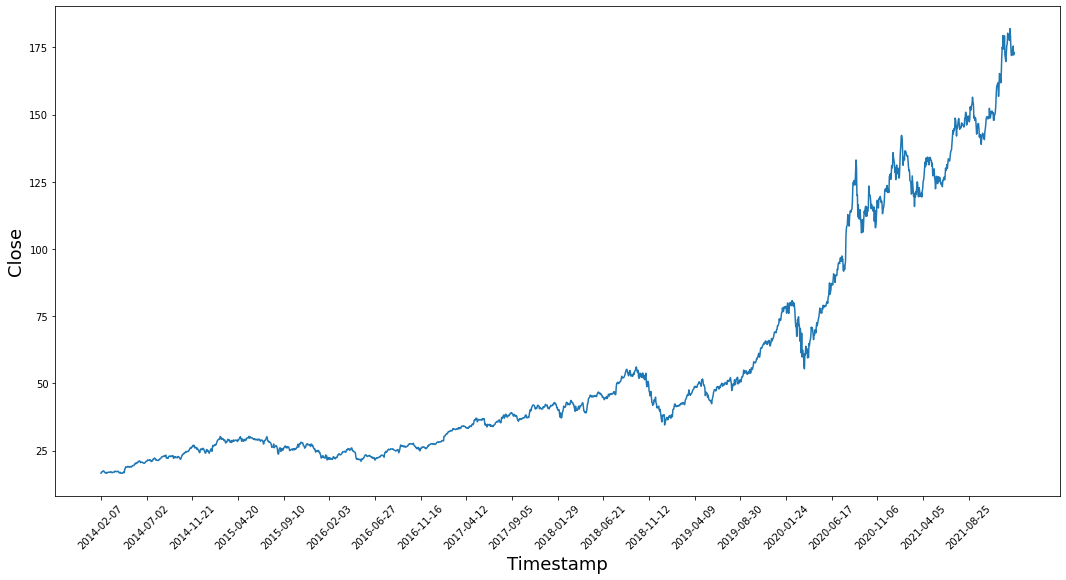

In [10]:
# preparing columns to use in model 
df = df.sort_values('Timestamp')
df.reset_index()
df = df.iloc[-2000:]
df_plot = df

# Plotting the data
plt.figure(figsize = (18,9))
plt.plot(range(df_plot.shape[0]),df_plot['Close'])
plt.xticks(range(0,df_plot.shape[0],100),df_plot['Timestamp'].loc[::100],rotation=45)
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('Close',fontsize=18)
plt.show()

In [11]:
# Variable and df preparation for scaling and dividing into sets
data = df_plot["Close"]
closing_price = data.values
split = int(len(df) * 0.75)
X_train = []
y_train = []

# Scaler
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data  = sc.fit_transform(closing_price.reshape(-1,1))

# Train scaling
training_data = scaled_data[0:split, :]

for i in range(60, len(training_data)):
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])
       
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)


# TEST
test_data = scaled_data[split-60:, :]
X_test = []
y_test = closing_price[split:,]

for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
X_test= np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)


(1440, 60, 1)
(500, 60, 1)


In [12]:
# Building Model:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)               

In [13]:
# Compiling and fitting model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 100, batch_size = 16)

Epoch 1/100
90/90 [==============================] - 3s 32ms/step - loss: 0.0013
Epoch 2/100
90/90 [==============================] - 3s 30ms/step - loss: 3.8376e-04
Epoch 3/100
90/90 [==============================] - 3s 30ms/step - loss: 3.4170e-04: 0s - lo
Epoch 4/100
90/90 [==============================] - 3s 31ms/step - loss: 2.6497e-04
Epoch 5/100
90/90 [==============================] - 3s 30ms/step - loss: 2.4584e-04
Epoch 6/100
90/90 [==============================] - 3s 31ms/step - loss: 2.4927e-04
Epoch 7/100
90/90 [==============================] - 3s 31ms/step - loss: 2.4135e-04
Epoch 8/100
90/90 [==============================] - 3s 32ms/step - loss: 2.0292e-04
Epoch 9/100
90/90 [==============================] - 3s 31ms/step - loss: 2.1665e-04
Epoch 10/100
90/90 [==============================] - 3s 31ms/step - loss: 1.8792e-04
Epoch 11/100
90/90 [==============================] - 3s 30ms/step - loss: 1.9592e-04
Epoch 12/100
90/90 [==============================] - 3s 3

90/90 [==============================] - 3s 30ms/step - loss: 8.1531e-05
Epoch 97/100
90/90 [==============================] - 3s 30ms/step - loss: 8.1437e-05
Epoch 98/100
90/90 [==============================] - 3s 30ms/step - loss: 9.4225e-05
Epoch 99/100
90/90 [==============================] - 3s 31ms/step - loss: 8.2190e-05
Epoch 100/100
90/90 [==============================] - 3s 32ms/step - loss: 8.4015e-05


In [14]:
# prediction with SC inversion
predictions = model.predict(X_test)
predictions = sc.inverse_transform(predictions)
predictions=np.transpose(predictions)[0]

print(predictions)

[ 79.6647    79.8433    79.44961   79.19019   79.58257   80.29908
  80.19837   79.39853   78.99637   79.285515  80.08855   80.68726
  80.952736  80.88183   81.05144   81.337654  81.58735   81.4376
  81.27618   81.08878   80.55673   79.146126  76.96889   75.142395
  73.18287   71.39539   71.43766   72.24457   73.59048   74.31987
  74.08441   72.191315  70.70649   69.78455   67.946434  67.20619
  65.84087   64.51665   63.351944  62.404922  60.947643  59.091534
  58.62198   59.2837    60.909668  62.01889   62.634422  62.875175
  62.22059   61.37079   60.63012   61.28885   62.649197  64.20449
  65.49972   66.55896   68.017365  69.381355  70.40988   70.82693
  70.51935   69.49196   68.761986  68.55383   69.10068   69.95431
  70.40458   70.856964  71.63247   72.22075   72.67494   73.224396
  73.925896  74.73131   75.78436   77.028625  77.90606   78.10384
  77.97901   77.74881   77.95572   78.38484   79.08205   79.65485
  80.048615  80.15796   80.15602   80.16176   80.18901   80.4267
  80.841

In [15]:
# RMSE calculation
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

6.113914607035697

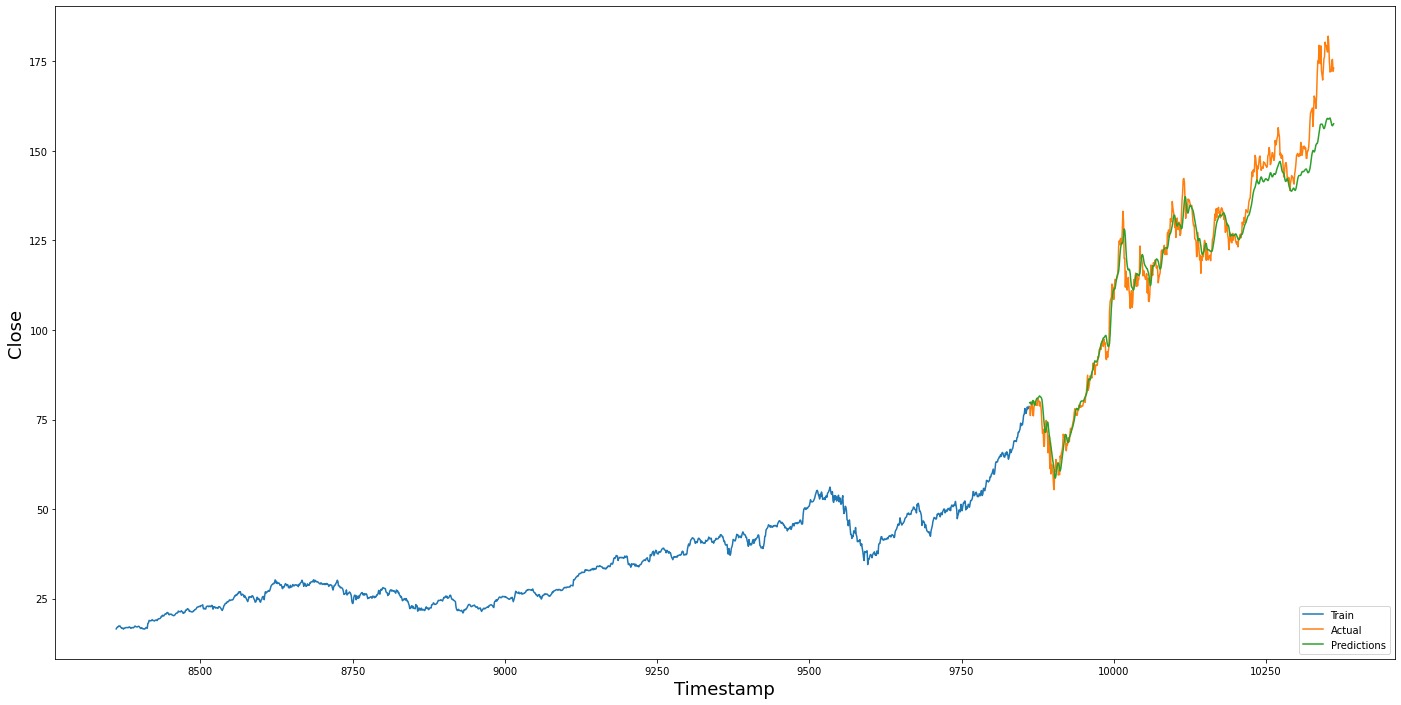

In [16]:
# preparing data for plotting
train = pd.DataFrame(data[:split])
valid = pd.DataFrame(data[split:])
valid["Predictions"] = predictions

# Plotting
plt.figure(figsize = (24,12))
plt.xlabel('Timestamp',fontsize=18)
plt.ylabel('Close',fontsize=18)
plt.plot(train)
plt.plot(valid[["Close", "Predictions"]])
plt.legend(["Train", "Actual", "Predictions"], loc = "lower right")
plt.show()

In [17]:
print(model.evaluate(X_test))

16/16 [==============================] - 0s 500us/step - loss: 0.0000e+00
0.0
